# Ch4 线性回归

## $\S4.2$ 线性回归的解析方法

## $\S4.3$ 动手实现线性回归的解析方法

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import sklearn.preprocessing

In [2]:
# 加载数据:
lines = np.loadtxt("Data/USA_Housing.csv", delimiter=",", dtype=str)
header = lines[0,:]
lines = lines[1:,:].astype(float)
print("数据特征:", ", ".join(header[:-1]))
print("数据标签:", header[-1])
print("数据总条数:", len(lines))

数据特征: Avg. Area Income, Avg. Area House Age, Avg. Area Number of Rooms, Avg. Area Number of Bedrooms, Area Population
数据标签: Price
数据总条数: 5000


In [3]:
# 数据划分:
ratio = 0.8
split = int(len(lines) * ratio)
np.random.seed(0)
lines = np.random.permutation(lines)
train, test = lines[:split, :], lines[split:, :]


In [4]:
# 数据标准化:
scaler = sklearn.preprocessing.StandardScaler()
## 注意只能利用训练集的信息fit your scaler.
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [5]:
# 划分输入标签:
## flatten将ndarray压缩成1darray
x_train, y_train = train[:,:-1], train[:,-1].flatten()
x_test, y_test = test[:,:-1], test[:,-1].flatten()

In [6]:
# 模型训练-计算回归系数:
## 在矩阵的最后一列上加上一列1，作为常数项:
X = np.concatenate([x_train, np.ones((len(x_train),1))], axis=1)
print(X.shape)
## @表示矩阵乘法，X.T表示矩阵转置, np.linalg.inv可以计算矩阵的逆:
theta = np.linalg.inv(X.T @ X) @ X.T @ y_train
print("回归系数:", theta)
## 在测试集上使用回归系数进行预测:
X_test = np.concatenate([x_test, np.ones((len(x_test),1))], axis=1)
y_pred = X_test @ theta

(4000, 6)
回归系数: [ 6.50881254e-01  4.67222833e-01  3.38466198e-01  6.17275855e-03
  4.26857089e-01 -1.48422941e-14]


In [7]:
# 模型评估:
## 计算预测值和真实值之间的RMSE
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print("RMSE:", rmse_loss)

RMSE: 0.2879183424717788


## $\S4.4$ 使用sklearn中的线性回归模型

In [8]:
import sklearn.linear_model
# 初始化线性回归模型
linreg = sklearn.linear_model.LinearRegression()
## sklearn的LinearRegression类中会自动考虑intercept, 所以直接训练
linreg.fit(x_train, y_train)
# 获取训练模型的系数和常数项:
print("回归系数:", linreg.coef_, linreg.intercept_)
# 预测样本
## 预测试还是需要加上intercept的位置
y_pred = linreg.predict(x_test)

回归系数: [0.65088125 0.46722283 0.3384662  0.00617276 0.42685709] -1.488873355007617e-14


In [9]:
# 模型评估
rmse_loss = np.sqrt(np.square(y_test - y_pred).mean())
print("RMSE:", rmse_loss)

RMSE: 0.28791834247177883


## $\S4.5$ 梯度下降算法

In [10]:
# 实现MBGD算法:
## 定义batch计算函数 
def batch_generator(x, y, batch_size, shuffle=True):
    """
    return: batch_size大小的数据
    shuffle: 如果为True,则每次遍历时会将数据重新划分
    """
    # 批量计数器
    batch_count = 0
    if shuffle:
        # 随机生成0到len(x)-1的下标
        idx = np.random.permutation(len(x))
        x = x[idx]
        y = y[idx]
    while True:
        start = batch_count * batch_size
        end = min(start + batch_size, len(x))
        if start >= end:
            # 已经遍历一遍，结束生成
            break
        batch_count += 1
        ## generator常用的返回关键字: 节省内存、支持迭代.
        yield x[start:end], y[start:end]

In [11]:
## 定义MBGD函数:
def MBGD(num_epoch, learning_rate, batch_size):
    # 拼接原始矩阵:
    X = np.concatenate([x_train, np.ones((len(x_train),1))], axis=1)
    X_test = np.concatenate([x_test, np.ones((len(x_test),1))], axis=1)
    # 随机化初始参数:
    theta = np.random.normal(size=X.shape[1])

    # 随机梯度下降
    ## 为了观察迭代过程，每次迭代后记录训练集和测试集上的RMSE
    train_losses = []
    test_losses = []
    for i in range(num_epoch):
        # 初始化批量生成器:
        batch_g = batch_generator(X, y_train, batch_size, shuffle=True)
        train_loss = 0
        for x_batch, y_batch in batch_g:
            # 计算梯度:
            grad = x_batch.T @ (x_batch @ theta - y_batch)
            # 更新参数:
            theta = theta - grad * learning_rate / len(x_batch)
            # 累加平方误差:
            train_loss += np.square(x_batch @ theta - y_batch).sum()
        # 计算训练和测试误差:
        train_loss = np.sqrt(train_loss / len(X))
        train_losses.append(train_loss)
        test_loss = np.sqrt(np.square(X_test @ theta - y_test).mean())
        test_losses.append(test_loss)
    
    # 输出结果
    print("回归系数:", theta)
    return theta, train_losses, test_losses

In [12]:
# 参数配置：
## epoch的含义在于: MBGD在理论上通过反复随机抽样进行迭代，大概率可以在平均意义上消除相对于N-GD的估计偏差.
num_epoch = 20
learning_rate = 0.01
batch_size = 32
## 随机数种子:必须每次进行随机行为前都运行随机数种子，重置随机状态；或者default_rng局部随机对象进行permutation.
np.random.seed(0)
## 进行梯度下降训练:
_, train_losses, test_losses = MBGD(num_epoch=num_epoch, learning_rate=learning_rate, batch_size=batch_size)

回归系数: [ 0.65357756  0.46682964  0.33885411  0.00720843  0.42751035 -0.00273407]


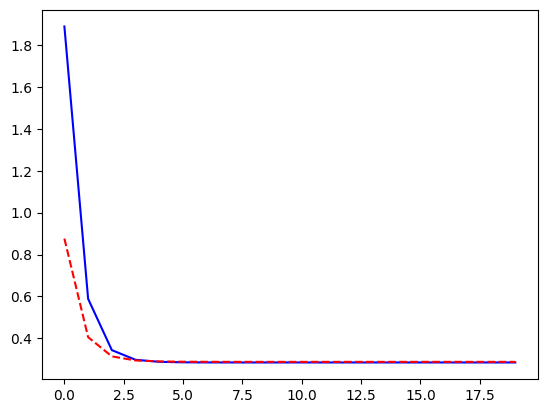

In [13]:
# 绘制损失函数曲线:
plt.plot(np.arange(num_epoch), train_losses, color="blue", label="train loss")
plt.plot(np.arange(num_epoch), test_losses, color="red", ls="--", label="test loss")

## $\S4.6$ 学习率对于迭代的影响

回归系数: [0.64542258 0.47047873 0.33188398 0.00325404 0.42479699 0.00237965]
回归系数: [0.59247915 0.58561574 0.26554358 0.10173112 0.49435997 0.13108641]


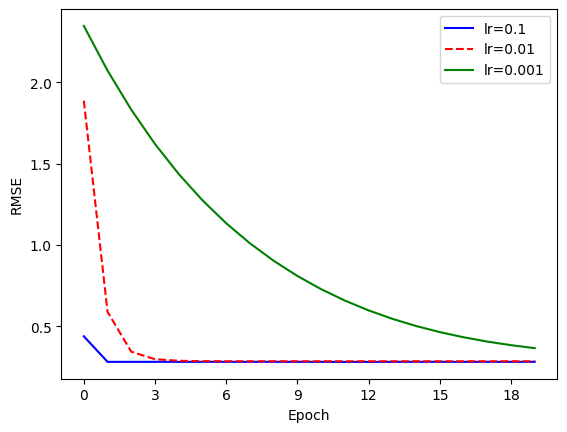

In [14]:
# 绘制不同学习率下的曲线:
_, loss1, _ = MBGD(num_epoch=num_epoch, learning_rate=0.1, batch_size=batch_size)
_, loss2, _ = MBGD(num_epoch=num_epoch, learning_rate=0.001, batch_size=batch_size)
plt.plot(np.arange(num_epoch), loss1, color="blue", label="lr=0.1")
plt.plot(np.arange(num_epoch), train_losses, color="red", ls="--", label="lr=0.01")
plt.plot(np.arange(num_epoch), loss2, color="green", ls="-" ,label="lr=0.001")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

回归系数: [ 1.02027002e+76 -1.13520960e+76  9.19403029e+75  5.66309421e+75
 -4.91084050e+75  5.35399924e+75]
最终损失: 5.336763816528037e+77


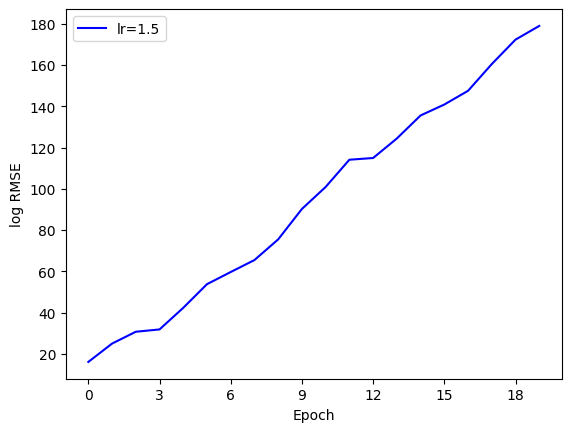

In [15]:
## 学习率过大并不是一件好事:
_, loss3, _ = MBGD(num_epoch=num_epoch, learning_rate=1.5, batch_size=batch_size)
print("最终损失:", loss3[-1])
plt.plot(np.arange(num_epoch), np.log(loss3), color="blue", label="lr=1.5")

plt.xlabel("Epoch")
plt.ylabel("log RMSE")
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

回归系数: [ 5.77637608e+79 -4.83668912e+80  3.25996550e+80  4.23825402e+80
  4.71711286e+80  2.86687588e+78]
最终损失： 5.561487013249977e+80


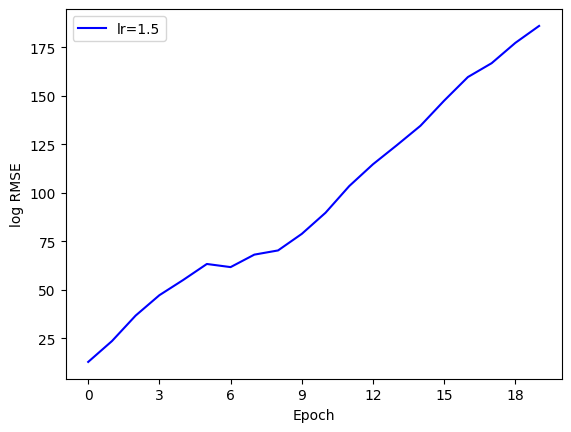

In [16]:
_, loss3, _ = MBGD(num_epoch=num_epoch, learning_rate=1.5, batch_size=batch_size)
print('最终损失：', loss3[-1])
plt.plot(np.arange(num_epoch), np.log(loss3), color='blue', label='lr=1.5')
plt.xlabel('Epoch')
plt.ylabel('log RMSE')
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

# HW4

## HW4.5 不同Batch_Size的影响

回归系数: [ 6.53315417e-01  4.69592236e-01  3.38226074e-01  6.46661280e-03
  4.27223793e-01 -3.52468377e-04]
回归系数: [6.50003140e-01 4.67419089e-01 3.37646214e-01 6.94633323e-03
 4.27266342e-01 4.39853585e-05]
回归系数: [ 0.70402536  0.41601563  0.43379306 -0.10489224  0.4003708   0.00450123]


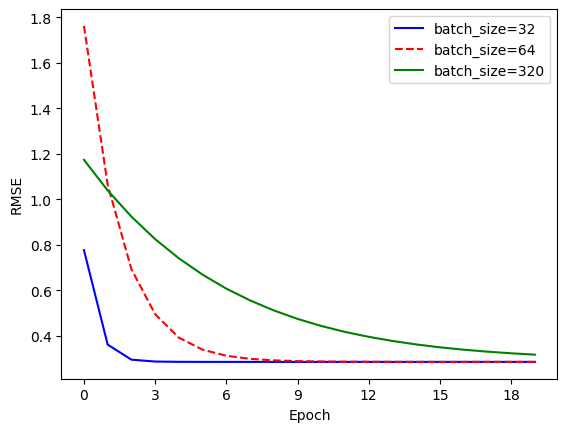

In [18]:
# 绘制不同Batch_Size下的曲线:
bz1 = 32
bz2 = 64
bz3 = 320

_, loss1, _ = MBGD(num_epoch=num_epoch, learning_rate=0.01, batch_size=bz1)
_, loss2, _ = MBGD(num_epoch=num_epoch, learning_rate=0.01, batch_size=bz2)
_, loss3, _ = MBGD(num_epoch=num_epoch, learning_rate=0.01, batch_size=bz3)
plt.plot(np.arange(num_epoch), loss1, color="blue", label=f"batch_size={bz1}")
plt.plot(np.arange(num_epoch), loss2, color="red", ls="--", label=f"batch_size={bz2}")
plt.plot(np.arange(num_epoch), loss3, color="green", ls="-" ,label=f"batch_size={bz3}")

plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()